## Processing Sensor Data from Catalina Jemez CZO BGZOB Pit 2
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS6
- Decagon5TE
- Vertical redox prodes from Paleo Terra

Issues:
- I'm not sure which water potential values are unrealistic
- O2 spike at about 2016-01 looks unrealistic


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
infiles = ["../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_co2o2_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_soilMTP_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BGZOB2_soilMTP_2017.csv"]  
        
infiles_redox = ["../../raw_data/Catalina-Jemez/BGZOB_Pit2/BigelowRedox_2015.csv", 
            "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BigelowRedox_2016.csv", 
             "../../raw_data/Catalina-Jemez/BGZOB_Pit2/BigelowRedox_2017.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
for infile in tqdm(infiles_redox):
    df2 = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1], usecols = ['DateTime','Pit2_ORP_5','Pit2_ORP_10','Pit2_ORP_30','Pit2_ORP_60']) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df2)


prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_BGZOB_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:


columns=['ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 
            'ApogeeTemp_100cm.deg.C', 'O2_10cm.percent.0-100','O2_30cm.percent.0-100', 
            'O2_60cm.percent.0-100', 'O2_100cm.percent.0-100', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 
            'CO2_60cm.ppm', 'CO2_100cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa', 
            'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3',
            'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_100cm.m3m3',
            'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_100cm.dS/m', 
            'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C',
            'Decagon5TETemp_100cm.deg.C','ReductionPotential_5cm.mV', 'ReductionPotential_10cm.mV',
            'ReductionPotential_30cm.mV', 'ReductionPotential_60cm.mV']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2013-03-08', '2014-11-21'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

In [4]:
df

,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,ApogeeTemp_100cm.deg.C,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,O2_100cm.percent.0-100,CO2_10cm.ppm,CO2_30cm.ppm,...,BulkEC_100cm.dS/m,Decagon5TETemp_10cm.deg.C,Decagon5TETemp_30cm.deg.C,Decagon5TETemp_60cm.deg.C,Decagon5TETemp_100cm.deg.C,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2014-11-20 11:00:00,9.58900,4.81450,5.89750,7.33550,20.86550,19.99100,19.38600,19.32900,1161.61900,3200.11950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 12:00:00,7.79500,5.17200,6.16000,7.59425,20.91125,20.29150,19.70000,19.62550,1150.26725,3206.03450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 13:00:00,6.76725,5.26725,6.16900,7.59900,20.89225,20.25600,19.69475,19.62100,1146.03175,3188.02425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 14:00:00,6.42875,5.35275,6.17125,7.59700,20.87025,20.23050,19.67075,19.63225,1150.99750,3174.14875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 15:00:00,6.04100,5.43050,6.16425,7.58425,20.85225,20.20600,19.67400,19.63225,1154.25475,3147.77150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,6.23625,6.93025,6.78300,7.28700,17.46925,19.45500,19.51825,21.52775,948.01400,1585.74950,...,0.0,5.775,6.200,6.7,7.075,565.250,559.900,681.80,640.425,NaN
2017-12-31 20:00:00,6.10500,6.95150,6.79350,7.28975,17.47725,19.45500,19.51900,21.52475,947.56050,1588.79025,...,0.0,5.625,6.200,6.7,7.125,566.550,560.500,681.80,640.625,NaN
2017-12-31 21:00:00,6.01400,6.97000,6.80250,7.29100,17.49225,19.45550,19.51775,21.52850,941.97850,1586.70275,...,0.0,5.475,6.200,6.7,7.075,567.675,561.025,681.80,640.675,NaN
2017-12-31 22:00:00,5.92300,6.98200,6.81425,7.29250,17.50700,19.46475,19.52325,21.53000,940.50375,1586.36225,...,0.0,5.350,6.275,6.7,7.175,568.550,561.400,681.85,640.850,NaN


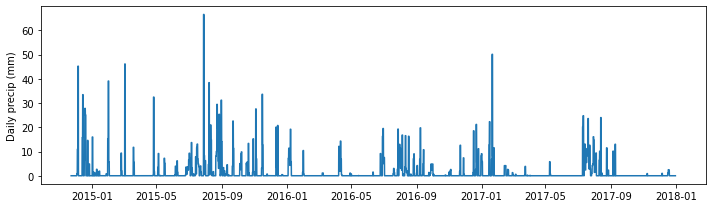

In [5]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

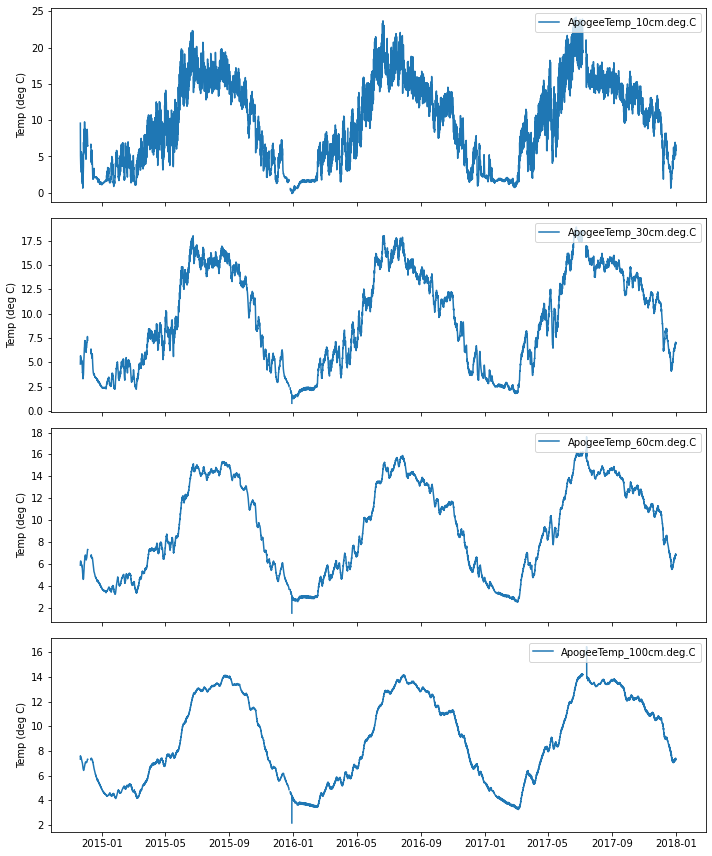

In [6]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

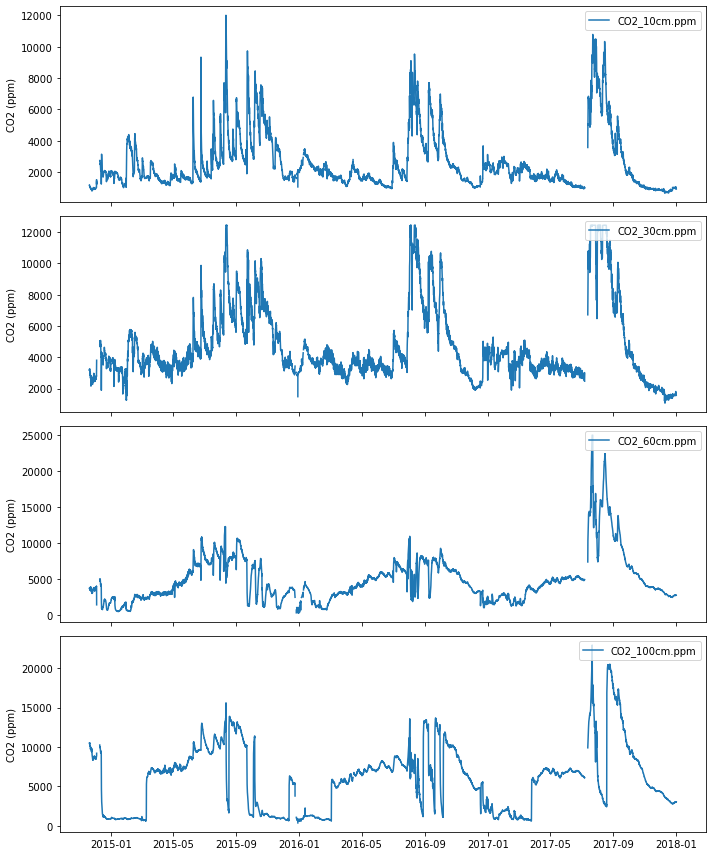

In [7]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

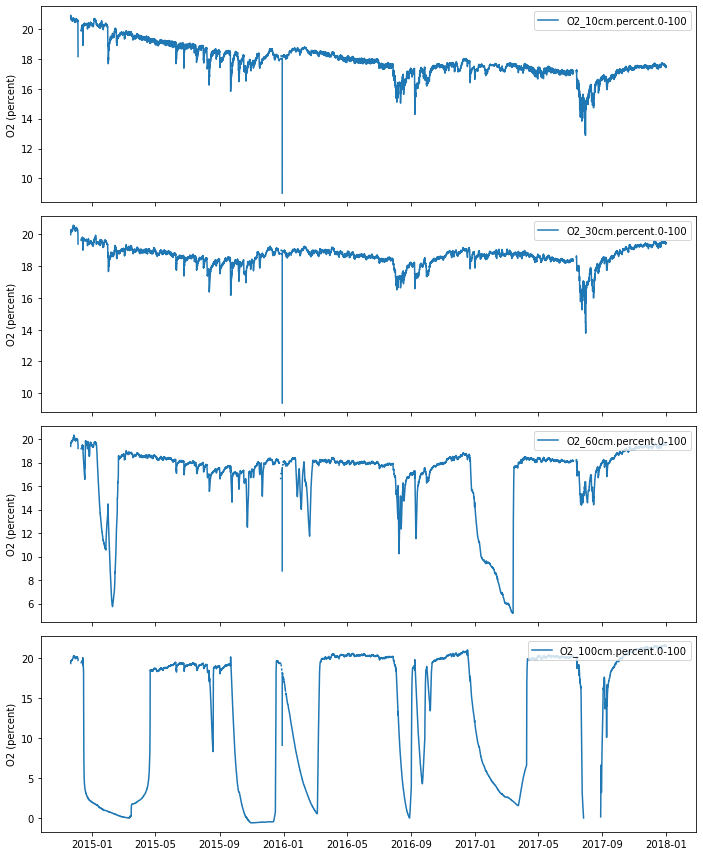

In [8]:
# Plot O2 data

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

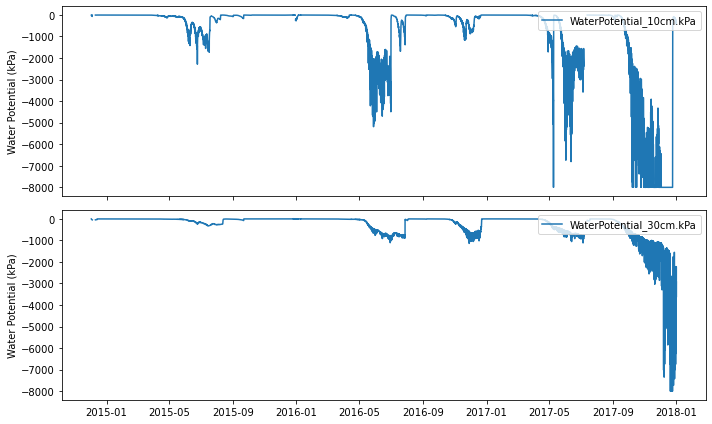

In [9]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

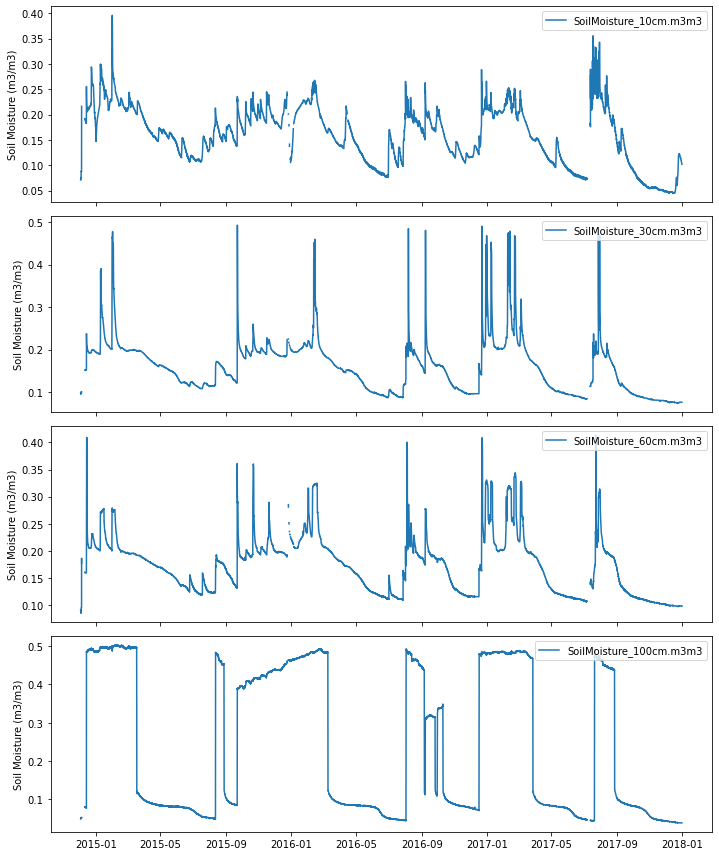

In [10]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

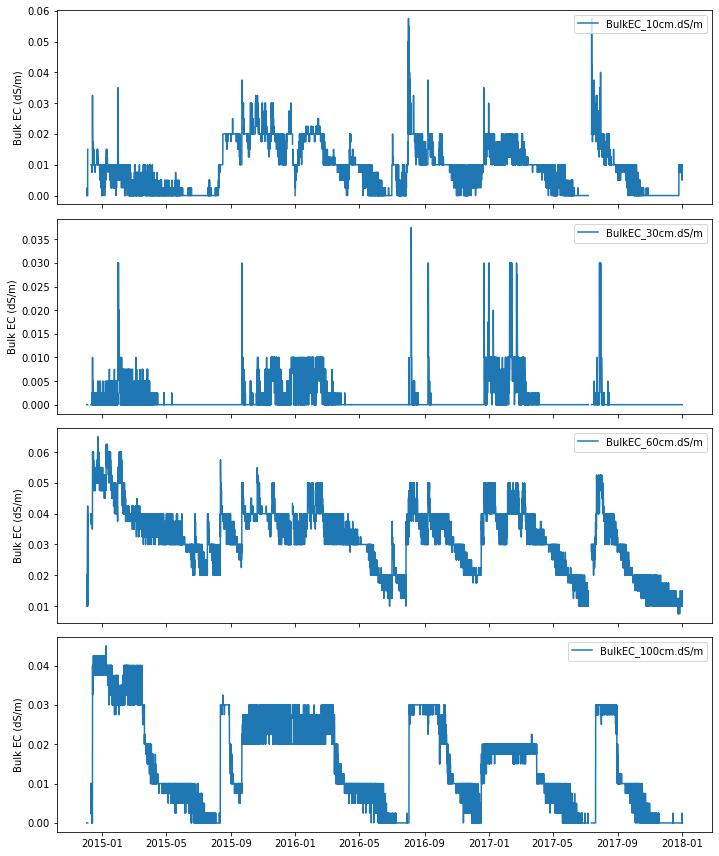

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

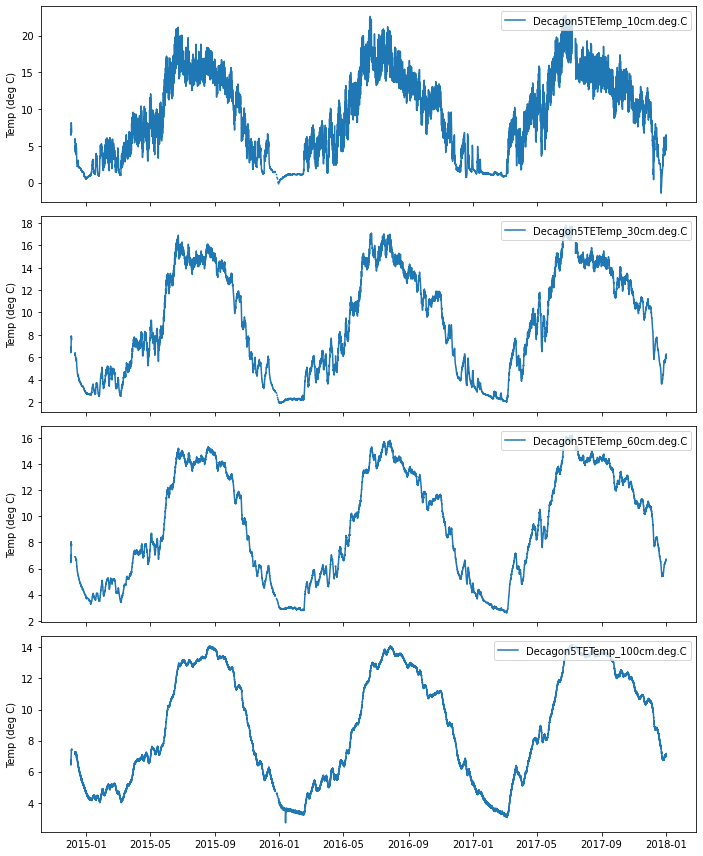

In [12]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [13]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_100cm.deg.C')

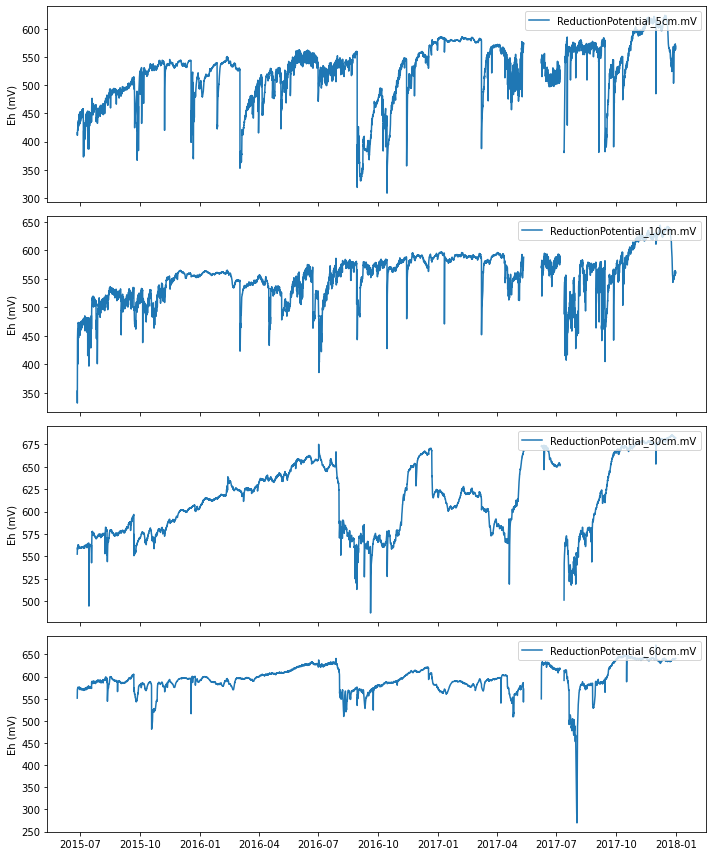

In [14]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/BGZOB_Pit2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,ApogeeTemp_100cm.deg.C,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,O2_100cm.percent.0-100,CO2_10cm.ppm,CO2_30cm.ppm,...,SoilMoisture_100cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_100cm.dS/m,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2014-11-20 11:00:00,9.58900,4.81450,5.89750,7.33550,20.86550,19.99100,19.38600,19.32900,1161.61900,3200.11950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 12:00:00,7.79500,5.17200,6.16000,7.59425,20.91125,20.29150,19.70000,19.62550,1150.26725,3206.03450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 13:00:00,6.76725,5.26725,6.16900,7.59900,20.89225,20.25600,19.69475,19.62100,1146.03175,3188.02425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 14:00:00,6.42875,5.35275,6.17125,7.59700,20.87025,20.23050,19.67075,19.63225,1150.99750,3174.14875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-20 15:00:00,6.04100,5.43050,6.16425,7.58425,20.85225,20.20600,19.67400,19.63225,1154.25475,3147.77150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,6.23625,6.93025,6.78300,7.28700,17.46925,19.45500,19.51825,21.52775,948.01400,1585.74950,...,0.039,0.0075,0.0,0.0125,0.0,565.250,559.900,681.80,640.425,NaN
2017-12-31 20:00:00,6.10500,6.95150,6.79350,7.28975,17.47725,19.45500,19.51900,21.52475,947.56050,1588.79025,...,0.039,0.0100,0.0,0.0100,0.0,566.550,560.500,681.80,640.625,NaN
2017-12-31 21:00:00,6.01400,6.97000,6.80250,7.29100,17.49225,19.45550,19.51775,21.52850,941.97850,1586.70275,...,0.039,0.0075,0.0,0.0150,0.0,567.675,561.025,681.80,640.675,NaN
2017-12-31 22:00:00,5.92300,6.98200,6.81425,7.29250,17.50700,19.46475,19.52325,21.53000,940.50375,1586.36225,...,0.039,0.0100,0.0,0.0100,0.0,568.550,561.400,681.85,640.850,NaN
